## Spectral scanner device test
Simple notebook to test the different components of the spectral scanner. The script assumes that the components are connected to a ESP32 microcontroller ([HUZZAH32](https://www.adafruit.com/product/3405)) running [MicroPython](https://micropython.org/).
The notebook uses [`pyboard.py`](https://docs.micropython.org/en/latest/reference/pyboard.py.html), a library that allows running MicroPython code via USB and [REPL](https://docs.micropython.org/en/latest/wipy/tutorial/repl.html) on the microcontroller.

The following tests are included:

   - Reading spectral data from the C12880MA breakout
   - Reading heading, pitch and roll (in [°]) from the compass breakout (CMPS12)
   - Move servos

In [1]:
import pyboard
import time
import json
import numpy as np
from pylab import *

pb = None

Generate a pyboard object on the COM port connected to the ESP32 (here `COM3`)

In [2]:
if pb is None:
    try:
        pb = pyboard.Pyboard("COM3")
    except pyboard.PyboardError as e:
        print(e)     

Enter REPL mode; the MicroPython "shell" is now ready to receive commands

In [3]:
pb.enter_raw_repl()   

Define a function that runs the code contained in a list of strings on the ESP32. By default, it does not print any text coming from the microcontroller into the history. The function returns the output of the last command as a string.

In [4]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res    

### C12880MA spectrometer

The following script is run on the ESP32: it import the C12880MA chip driver and generates a C12880MA by passing the pins to which it is connected. Then it initializes the driver and sets the integration time (in [s]). The script returns a list of wavelengths (in [nm]) at which the spectrometer chip performs the measurements.
As `run_on_board` returns a string, the `json` library is used to convert it to a Python list.

In [5]:
script = [
    'from driver.c12880ma import C12880MA',
    'import board',
    'sp = C12880MA(trg=board.TRG, st=board.STA, clk=board.CLK, video=board.VID)',
    'sp.begin()',
    'sp.setIntegrationTime_s(0.01)',
    'print(list(sp.wavelengths))'
]
nm = json.loads(run_on_board(script, wait_s=0.4, no_print=True))

Here is a picture of the test circuit:

<p align="center">
  <img width="720" src="https://github.com/eulerlab/spectral-scanner/blob/main/pics/Wiring_c12880_test.png?raw=true"></img>
</p>

Define a function that reads a spectrum from the C12880MA chip and returns it as a list.

In [6]:
def get_spectrum():
    script = [
        'sp.read()',
        'print(list(sp.spectrum))'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    return raw

Finally, test the functionality: Read a new spectrum (`data`) and plot it as a function of wavelength (`nm`). 

(0.0, 4095.0)

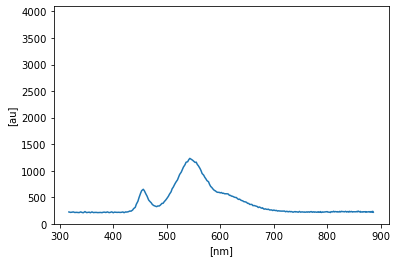

In [21]:
data = get_spectrum()
plot(nm, data)
ylabel("[au]")
xlabel("[nm]")
ylim(0,4095)

### CMPS12 tilt-compensated compass module

Read heading, pitch and roll from the compass breakout (connected via the I2C bus)

In [34]:
script = [
    'from driver.busio import I2CBus',
    'from driver.compass_cmps12 import Compass',
    'i2c = I2CBus(board.I2C_FRQ, board.SCL, board.SDA, code=0)',
    'compass = Compass(i2c)'
]
_ = run_on_board(script, wait_s=0.4, no_print=False)

Hardware #0 I2C bus frequency is 400.0 kHz
Scanning I2C bus ...
... 1 device(s) found ([96])
[   CMPS12_v2] Compass w/ tilt-compensation        (0.1.1.0): ok


In [35]:
for i in range(10):
    errC, head, pitch, roll = json.loads(run_on_board(['print(list(compass.getHeading3D()))'], no_print=True))
    print("heading={0:.0f}°, pitch={1}°, roll={2}°".format(head, pitch, roll))
    time.sleep(1.0)

heading=25°, pitch=108°, roll=-2°
heading=25°, pitch=108°, roll=-2°
heading=25°, pitch=108°, roll=-2°
heading=25°, pitch=108°, roll=-2°
heading=242°, pitch=48°, roll=26°
heading=262°, pitch=68°, roll=26°
heading=5°, pitch=107°, roll=3°
heading=344°, pitch=108°, roll=3°
heading=340°, pitch=108°, roll=3°
heading=339°, pitch=108°, roll=3°


### Servos

Move servos connected to pins `board.SERVO_PAN` and `board.SERVO_TLT`.

In [14]:
script = [
    'import time',
    'import board',
    'from driver.servo import Servo',
    'servoPan = Servo(board.SERVO_PAN, us_range=board.PAN_RANGE_US, \
                      ang_range=board.PAN_RANGE_DEG, verbose=True)',
    'servoTlt = Servo(board.SERVO_TLT, us_range=board.TLT_RANGE_US, \
                      ang_range=board.TLT_RANGE_DEG, verbose=True)'
]
_ = run_on_board(script, wait_s=0.4, no_print=False)

Servo at pin 27 (50 Hz) ready.
Servo at pin 33 (50 Hz) ready.


In [15]:
for i in range(3):
    run_on_board(['servoPan.angle = 0', \
                  'servoTlt.angle = 0'], no_print=True)
    time.sleep(1.0)
    run_on_board(['servoPan.angle =-60', \
                  'servoTlt.angle =+60'], no_print=True)
    time.sleep(1.0)
    run_on_board(['servoPan.angle = +60', \
                  'servoTlt.angle = -60'], no_print=True)
    time.sleep(1.0)

_ = run_on_board(['servoPan.angle = 0', \
                  'servoTlt.angle = 0'], no_print=True)